In [1]:
"""
"""

from datetime import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from shapely.geometry import Point, Polygon

from util import get_shapefile_filename, get_shapefile_filepath

%matplotlib inline


# This time around, this is the data of interest:
counties = ['middlesex', 'norfolk', 'suffolk']

data_filepath = './data/mount/201805/filtered/20180507_20180511/county_middlesex_norfolk_suffolk_3days_3nights.csv'
# data_filepath = './data/mount/201805/filtered/20180500_20180514/county_middlesex_norfolk_suffolk_7days_6nights.csv'


In [2]:
# Column names defined as variables
COUNTY = 'COUNTY'


# Columns from the census area shapefiles
GEOID = 'GEOID10'

# Columns added
TRACT = 'TRACT'
BLOCKGROUP = 'BLOCKGROUP'
BLOCK = 'BLOCK'


In [3]:
df = pd.read_csv(data_filepath)
print(df.shape)

(524810, 9)


## Attach census tract

reading shapefile ./shapefiles/ma/tract_middlesex_norfolk_suffolk.shp


,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,ALAND10,AWATER10,INTPTLAT10,...,AREA_ACRES,POP100_RE,HU100_RE,LOGPL94171,LOGSF1,LOGACS0610,LOGSF1C,SHAPE_AREA,SHAPE_LEN,geometry
0,25,021,418003,25021418003,4180.03,Census Tract 4180.03,G5020,1705668.0,2936.0,+42.2350240,...,422.1740,2481,1350,0141872,123764,0003690,0123764,1.708484e+06,6274.185034,POLYGON ((-71.00721256587961 42.23014165019458...
1,25,021,417701,25021417701,4177.01,Census Tract 4177.01,G5020,1543651.0,12275.0,+42.2523398,...,384.4502,5417,2983,0141838,123730,0003683,0123730,1.555821e+06,6229.137913,POLYGON ((-71.00345056634727 42.26050865653624...
2,25,021,417702,25021417702,4177.02,Census Tract 4177.02,G5020,1685529.0,317947.0,+42.2582818,...,416.4918,2765,1109,0141843,123735,0003684,0123735,1.685489e+06,8542.498286,POLYGON ((-70.98695456210277 42.26423765714259...


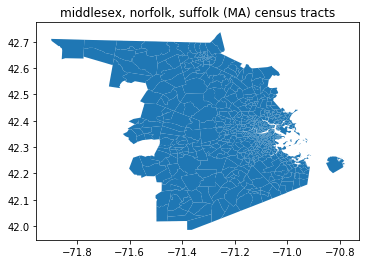

In [4]:
# Load in the shapefile
tracts_shapefile_filepath = get_shapefile_filepath('ma', 'tract', counties)
print('reading shapefile', tracts_shapefile_filepath)

tracts_shapefile = gpd.read_file(tracts_shapefile_filepath).to_crs(epsg=4326)
tracts_shapefile.plot()
plt.title(', '.join(counties) + ' (MA) census tracts')

tracts_shapefile.head(3)

In [ ]:

MA_CODE = '25'


def get_geoid_prefix(data_row):
    county_code = str(data_row[COUNTY])
    county_code = ('0' + county_code) if len(county_code) < 3 else county_code
    return MA_CODE + county_code

def get_tract(data_row, shapefile=tracts_shapefile):
    lat = float(data_row['lat'])
    lon = float(data_row['lon'])
    geoid_prefix = get_geoid_prefix(data_row)
    point = Point(lon, lat) # the points actually reverse - yes this looks weird but consider lon the x-axis and lat the y-axis on an x-y plane...
    for i, shp_row in shapefile.iterrows():
        tract_geoid = shp_row[GEOID]
        if not tract_geoid.startswith(geoid_prefix):
            continue
        try:
            # this could be a Polygon or a Multipolygon when the tract contains islands (<3 New England)
            polygon = shp_row['geometry']
            if point.within(polygon):
                return tract_geoid
        except Exception as e:
            print('Exception when looking for point in tract ' + tract_geoid, ': ', e)
            raise e
    print('No tract found for data row!', data_row)
    return None

areas_df = df
areas_df[TRACT] = areas_df.apply(get_tract, axis=1)

In [ ]:
# areas_df.head()

In [ ]:
# Which points were not able to get assigned tracts?
# plot these lat,lon points that have no assigned tract on top of the tracts shapefile

null_areas_df = areas_df[areas_df.isnull().any(axis=1)]
print('%s/%s = %s points in dataset where unable to assign census tract' % (
    null_areas_df.shape[0], areas_df.shape[0], null_areas_df.shape[0]/areas_df.shape[0]))

tractless_points_geometry = [Point(xy) for xy in zip(null_areas_df["lon"], null_areas_df["lat"])]
# Plot them 
tractless_points_df = gpd.GeoDataFrame(null_areas_df,crs={'init': 'espg:4326'},geometry=tractless_points_geometry)
fix,ax = plt.subplots(figsize=(12,12))
tracts_shapefile.plot(ax=ax)
tractless_points_df.plot(ax=ax, markersize=5, color='orange')

Upon inspection, we see that there are datapoints that are in the water!
This is why they were not assigned census tracts. They are dropped.

In [ ]:
areas_df = areas_df.dropna()

In [10]:
# Save the data
areas_df.to_csv(data_filepath, index=False)

## Attach blockgroup

Using the fact that blockgroup GEOID is prefixed by tract GEOID

reading shapefile ./shapefiles/ma/blockgroup_middlesex_norfolk_suffolk.shp


,STATEFP10,COUNTYFP10,TRACTCE10,BLKGRPCE10,GEOID10,NAMELSAD10,MTFCC10,ALAND10,AWATER10,INTPTLAT10,...,AREA_ACRES,POP100_RE,HU100_RE,LOGPL94171,LOGSF1,LOGACS0610,LOGSF1C,SHAPE_AREA,SHAPE_LEN,geometry
0,25,021,456402,2,250214564022,Block Group 2,G5030,5107660.0,104225.0,+42.0980485,...,1287.7929,1331,465,0142091,123983,0007625,0123983,5.211534e+06,9996.085232,POLYGON ((-71.09325358686991 42.09046962120169...
1,25,021,456402,1,250214564021,Block Group 1,G5030,4674851.0,343496.0,+42.0856597,...,1239.9721,981,312,0142090,123982,0007624,0123982,5.018009e+06,10171.313638,POLYGON ((-71.11289359194581 42.08290061881614...
2,25,021,456402,3,250214564023,Block Group 3,G5030,3420837.0,237352.0,+42.1168451,...,903.8929,2387,801,0142092,123984,0007626,0123984,3.657940e+06,8622.142376,POLYGON ((-71.11841459590471 42.12182462643546...


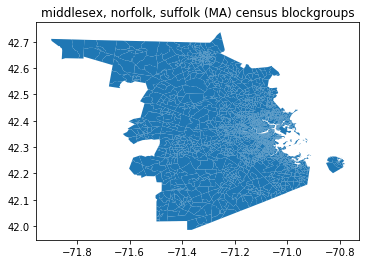

In [11]:
# Load in the shapefile
blockgroups_shapefile_filepath = get_shapefile_filepath('ma', 'blockgroup', counties)
print('reading shapefile', blockgroups_shapefile_filepath)

blockgroups_shapefile = gpd.read_file(blockgroups_shapefile_filepath).to_crs(epsg=4326)
blockgroups_shapefile.plot()
plt.title(', '.join(counties) + ' (MA) census blockgroups')

blockgroups_shapefile.head(3)

In [ ]:
print('getting and attaching blockgroup for %s lat,lon points' % areas_df.shape[0])

def get_blockgroup(data_row, shapefile=blockgroups_shapefile):
    if random.randint(1, 10000) == 10000:
        print(datetime.now(), ":1/10000: get_blockgroup")
    lat = float(data_row['lat'])
    lon = float(data_row['lon'])
    geoid_prefix = data_row[TRACT]
    point = Point(lon, lat) # the points actually reverse - yes this looks weird but consider lon the x-axis and lat the y-axis on an x-y plane...
    for i, shp_row in shapefile.iterrows():
        blockgroup_geoid = shp_row[GEOID]
        if not blockgroup_geoid.startswith(geoid_prefix):
            continue
        try:
            # this could be a Polygon or a Multipolygon when the tract contains islands (<3 New England)
            polygon = shp_row['geometry']
            if point.within(polygon):
                return blockgroup_geoid
        except Exception as e:
            print('Exception when looking for point in blockgroup ' + blockgroup_geoid, ': ', e)
            raise e
    print('No blockgroup found for data row!', data_row)
    return None

areas_df[BLOCKGROUP] = areas_df.apply(get_blockgroup, axis=1)

## Attach block

Using the fact that block GEOID is prefixed by tract GEOID (see https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html)

In [ ]:
# Load in the shapefile
blocks_shapefile_filepath = get_shapefile_filepath('ma', 'block', counties)
print('reading shapefile', blocks_shapefile_filepath)

blocks_shapefile = gpd.read_file(blocks_shapefile_filepath).to_crs(epsg=4326)
blocks_shapefile.plot()
plt.title(', '.join(counties) + ' (MA) census blocks')

blocks_shapefile.head(3)

In [ ]:

def get_block(data_row, shapefile=blocks_shapefile):
    if random.randint(1, 10000) == 10000:
        print(datetime.now(), ":1/10000: get_block")
    lat = float(data_row['lat'])
    lon = float(data_row['lon'])
    geoid_prefix = data_row[TRACT] # NOT prefixed by the blockgroup
    point = Point(lon, lat) # the points actually reverse - yes this looks weird but consider lon the x-axis and lat the y-axis on an x-y plane...
    for i, shp_row in shapefile.iterrows():
        block_geoid = shp_row[GEOID]
        if not block_geoid.startswith(geoid_prefix):
            continue
        try:
            # this could be a Polygon or a Multipolygon when the tract contains islands (<3 New England)
            polygon = shp_row['geometry']
            if point.within(polygon):
                return block_geoid
        except Exception as e:
            print('Exception when looking for point in block ' + block_geoid, ': ', e)
            raise e
    print('No block found for data row!', data_row)
    return None

areas_df[BLOCK] = areas_df.apply(get_block, axis=1)

areas_df.head()